### 광고 키워드 추천  
- 키워드 데이터 추출  
- 키워드별 노출수와 랭킹  
- 타게팅에 대한 f(x)

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns

from datetime import date, timedelta


나이 타겟팅을 위한 3살 단위로 나이별 그룹 나누기

In [58]:
age_group = []
i = 11
while i < 92:
    age_group.append((i, i+3))
    i += 3

In [83]:
case = ''
for i, j in age_group:
    case += 'when user_age between {} and {} then {}\n '.format(i-1, j-1, '\'' + str(i) + '-' + str(j) + '\'')

In [84]:
print(case)

when user_age between 10 and 13 then '11-14'
 when user_age between 13 and 16 then '14-17'
 when user_age between 16 and 19 then '17-20'
 when user_age between 19 and 22 then '20-23'
 when user_age between 22 and 25 then '23-26'
 when user_age between 25 and 28 then '26-29'
 when user_age between 28 and 31 then '29-32'
 when user_age between 31 and 34 then '32-35'
 when user_age between 34 and 37 then '35-38'
 when user_age between 37 and 40 then '38-41'
 when user_age between 40 and 43 then '41-44'
 when user_age between 43 and 46 then '44-47'
 when user_age between 46 and 49 then '47-50'
 when user_age between 49 and 52 then '50-53'
 when user_age between 52 and 55 then '53-56'
 when user_age between 55 and 58 then '56-59'
 when user_age between 58 and 61 then '59-62'
 when user_age between 61 and 64 then '62-65'
 when user_age between 64 and 67 then '65-68'
 when user_age between 67 and 70 then '68-71'
 when user_age between 70 and 73 then '71-74'
 when user_age between 73 and 76 th

일주일 전 날짜에 노출된 상품 대상

In [102]:
date = date.today() - timedelta(days = 7)
print('Data extracted from ', date)

q = '''
SELECT i.imp_id,
       i.ref_term,
       i.content_position,
       i.device_type,
       u.sex,
       CAST(Coalesce(NULL, Ceil((Extract(DAY
                                    FROM Getdate() - u.birthdate :: timestamptz) / 365.25)), 0) AS int) AS user_age,
       CASE 
       {}END AS age_group
FROM bun_log_db.app_event_type_impression i
JOIN
  (SELECT ref_term
   FROM bun_log_db.app_event_type_impression
   WHERE ref_term IS NOT NULL
     AND device_type IN ('a')
     AND YEAR||MONTH||DAY = {}
   GROUP BY 1
   ORDER BY count(*) DESC
   LIMIT 1000) t ON i.ref_term = t.ref_term
JOIN service1_quicket.user_extra_info u ON i.user_id = u.uid
WHERE i.year||i.month||i.day = {}
  AND i.device_type IN ('a')
  AND u.is_identification = 1
  AND To_date(u.birthdate, 'YYYY-MM-DD') BETWEEN '1930-01-01' AND '2010-12-31'
  AND page_id = '검색결과'
'''.format(case, '\'' + date.strftime('%Y%m%d') + '\'', '\'' + date.strftime('%Y%m%d') + '\'')
df = pd.read_sql(q, con=bun_dw)

Data extracted from  2020-08-14

SELECT i.imp_id,
       i.ref_term,
       i.content_position,
       i.device_type,
       u.sex,
       CAST(Coalesce(NULL, Ceil((Extract(DAY
                                    FROM Getdate() - u.birthdate :: timestamptz) / 365.25)), 0) AS int) AS user_age,
       CASE 
       when user_age between 10 and 13 then '11-14'
 when user_age between 13 and 16 then '14-17'
 when user_age between 16 and 19 then '17-20'
 when user_age between 19 and 22 then '20-23'
 when user_age between 22 and 25 then '23-26'
 when user_age between 25 and 28 then '26-29'
 when user_age between 28 and 31 then '29-32'
 when user_age between 31 and 34 then '32-35'
 when user_age between 34 and 37 then '35-38'
 when user_age between 37 and 40 then '38-41'
 when user_age between 40 and 43 then '41-44'
 when user_age between 43 and 46 then '44-47'
 when user_age between 46 and 49 then '47-50'
 when user_age between 49 and 52 then '50-53'
 when user_age between 52 and 55 then '53-5

KeyboardInterrupt: 

In [103]:
df.head(10)

,imp_id,ref_term,content_position,device_type,sex,user_age,age_group
0,97b95f3606361529e14e,아이폰,6,a,2,27,26-29
1,970a5f35ff1014fe8743,구찌,295,a,2,44,44-47
2,99ad5f3600a71500879f,방탄소년단,26,a,1,14,14-17
3,971b5f360a6915406409,선반,103,a,2,40,38-41
4,971b5f360ad015429d66,에쿠스,345,a,2,44,44-47
5,971b5f360956153a6d68,바람막이,143,a,2,20,20-23
6,99ad5f36083a15284448,구찌,115,a,2,43,41-44
7,970a5f3602fb1512a373,메모리즈 포카,11,a,1,27,26-29
8,99ad5f360626151d1e27,축구화,102,a,2,33,32-35
9,970a5f36043b1518f997,구찌,635,a,1,34,32-35


## 성별 비율  
#### 0: none, 1: female, 2: male

In [104]:
df.groupby('sex')['imp_id'].agg(lambda x: len(x)/len(df))

sex
0    0.004097
1    0.403028
2    0.592875
Name: imp_id, dtype: float64

## 나이 비율

In [105]:
df.groupby('age_group')['imp_id'].agg(lambda x: round(len(x)/len(df)*100, 2))

age_group
11-14     0.33
14-17     4.53
17-20     8.95
20-23     9.00
23-26     8.49
26-29    25.07
29-32     6.73
32-35     5.12
35-38     5.37
38-41     6.44
41-44     5.33
44-47     4.56
47-50     3.42
50-53     2.75
53-56     1.35
56-59     0.85
59-62     0.73
62-65     0.48
65-68     0.14
68-71     0.09
71-74     0.04
74-77     0.02
77-80     0.06
80-83     0.13
83-86     0.01
89-92     0.03
Name: imp_id, dtype: float64

## 키워드별 노출 수

In [106]:
keywords_df = df.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False).reset_index(drop=True)
keywords_df.columns = ['ref_term', 'imp_cnt']

In [107]:
keywords_df.head(10)

,ref_term,imp_cnt
0,원피스,123381
1,나이키,97844
2,아이폰,92667
3,시계,83620
4,구찌,83225
5,방탄,72358
6,피규어,64262
7,14k,58814
8,자전거,54834
9,픽시,51499


Text(0, 0.5, 'Imp. Count')

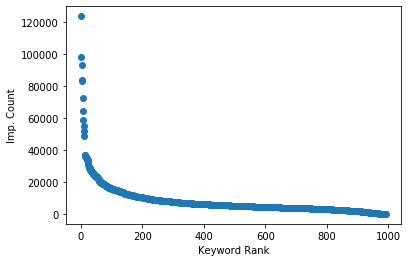

In [108]:
plt.scatter(np.arange(1,len(keywords_df)+1), keywords_df['imp_cnt'])
plt.xlabel('Keyword Rank')
plt.ylabel('Imp. Count')

### Rank 1 keyword: 원피스  
#### '원피스' 키워드에 대한 포지션에 따른 노출수

In [122]:
df['content_position'] = df['content_position'].astype(int)
one_piece = df[df['ref_term'] == '원피스'].groupby('content_position', as_index=False)['imp_id'].count().sort_values('content_position')

In [123]:
one_piece.columns = ['content_position', 'imp_cnt']

In [33]:
one_piece.head(20)

,content_position,imp_cnt
0,0,1427
1,1,1436
2,2,1441
3,3,453
4,4,453
5,5,409
6,6,400
7,7,401
8,8,400
9,9,387


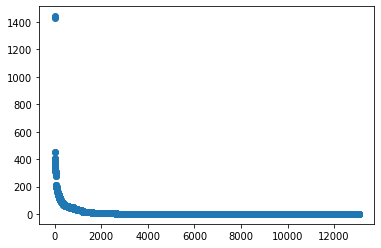

In [21]:
import matplotlib.pyplot as plt

plt.scatter(one_piece['content_position'], one_piece['imp_cnt'])

In [28]:
import numpy as np
x = np.array(one_piece['content_position'])
y = np.array(one_piece['imp_cnt'])
np.polyfit(np.exp(-x), y, 0.5)

array([9.43929309])

In [44]:
dec = [0]
for i in range(1, len(one_piece)):
    dec.append(round((one_piece.loc[i-1, 'imp_cnt'] - one_piece.loc[i, 'imp_cnt'])/one_piece.loc[i-1, 'imp_cnt']*100, 2))
one_piece['decrease'] = dec

In [89]:
one_piece[one_piece['decrease']>0]

,content_position,imp_cnt,decrease
3,3,453,68.56
5,5,409,9.71
6,6,400,2.20
8,8,400,0.25
9,9,387,3.25
11,11,388,0.26
12,12,366,5.67
14,14,366,0.27
15,15,353,3.55
16,16,351,0.57


In [88]:
from sklearn.linear_model import LinearRegression
import numpy as np

x = np.array(one_piece[one_piece['decrease']>0].index).reshape((-1, 1))
y = np.array(one_piece[one_piece['decrease']>0]['decrease'])
lr = LinearRegression()
lr.fit(x, y)
print('coefficient of determination:', lr.score(x, y))

coefficient of determination: 0.5337722677310934


In [94]:
print('y = ' + str(round(lr.coef_[0], 4)) + 'x ' + str(round(lr.intercept_, 4)))

y = 0.0076x -0.6556


In [101]:
x = np.array(one_piece[one_piece['decrease']>0]['content_position'])
y = np.array(one_piece[one_piece['decrease']>0]['decrease'])
np.polyfit(x**2, y, 0.1)

array([4.45985816])

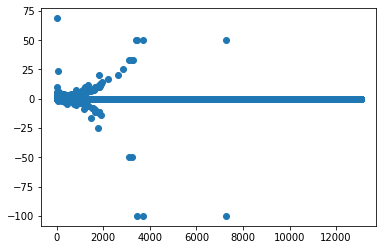

In [50]:
plt.scatter(one_piece.index, one_piece['decrease'])

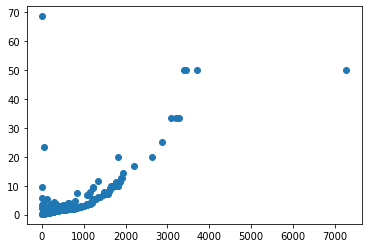

In [95]:
plt.scatter(one_piece[one_piece['decrease']>0].index, one_piece[one_piece['decrease']>0]['decrease'])

- content position의 숫자가 커질수록 노출수가 줄어드는 percentage가 positive/negative 왔다갔다함  
- 현재 노출이 3단위로 되어서인지 content position이 3의 배수인 것들만 봤을 때는 노출수가 줄어드는 Percentage가 양수  
-> 노출 content position이 3의 배수인 것만 보기
* content position이 0에서 3으로 하락세를 봤을때 차이가 너무 크니깐 content position이 0인것은 제외해도 될것같음


In [124]:
# del one_piece['decrease']
one_piece['content_position'] = one_piece['content_position'].astype(int)
one_piece = one_piece[(one_piece['content_position'] <= 15)&(one_piece['content_position'] % 3 == 0)].reset_index(drop=True)
one_piece

,content_position,imp_cnt
0,0,1427
1,3,453
2,6,400
3,9,387
4,12,366
5,15,353


In [125]:
dec = [0]
for i in range(1, len(one_piece)):
    dec.append(round((one_piece.loc[i-1, 'imp_cnt'] - one_piece.loc[i, 'imp_cnt'])/one_piece.loc[i-1, 'imp_cnt']*100, 2))
one_piece['decrease'] = dec
one_piece

,content_position,imp_cnt,decrease
0,0,1427,0.00
1,3,453,68.26
2,6,400,11.70
3,9,387,3.25
4,12,366,5.43
5,15,353,3.55


### Rank 2 keyword: 나이키  
#### '나이키' 키워드에 대한 포지션에 따른 노출수

In [30]:
nike = df[df['ref_term'] == '나이키'].groupby('content_position', as_index=False)['imp_id'].count().sort_values('content_position')
nike.columns = ['content_position', 'imp_cnt']
nike.head()

,content_position,imp_cnt
0,0,1969
1,1,2011
2,2,2005
3,3,646
4,4,638


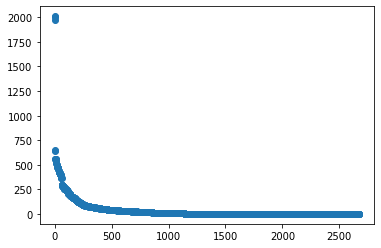

In [31]:
plt.scatter(nike['content_position'], nike['imp_cnt'])

In [32]:
x = np.array(nike['content_position'])
y = np.array(nike['imp_cnt'])
np.polyfit(np.exp(-x), y, 0.5)

array([36.56352765])

In [51]:
dec = [0]
for i in range(1, len(nike)):
    dec.append(round((nike.loc[i-1, 'imp_cnt'] - nike.loc[i, 'imp_cnt'])/nike.loc[i-1, 'imp_cnt']*100, 2))
nike['decrease'] = dec

In [53]:
nike

,content_position,imp_cnt,decrease
0,0,1969,0.00
1,1,2011,-2.13
2,2,2005,0.30
3,3,646,67.78
4,4,638,1.24
5,5,563,11.76
6,6,556,1.24
7,7,556,0.00
8,8,556,0.00
9,9,538,3.24


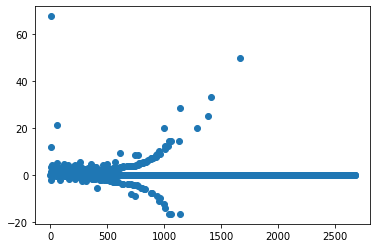

In [52]:
plt.scatter(nike.index, nike['decrease'])

## 키워드별 상위 5개 (content_position <= 15 & 3의 배수)의 랭킹순 하락도

In [131]:
keywords = df['ref_term'].unique()
keyword_stat = {}
dt = df[(df['content_position'] <= 15) & (df['content_position'] % 3 == 0)]
for k in keywords:
    temp = one_piece = dt[dt['ref_term'] == k].groupby('content_position', as_index=False)['imp_id'].count().sort_values('content_position')
    temp.columns = ['ref_term', 'imp_cnt']
    dec = [0]
    for i in range(1, len(temp)):
        dec.append(round((temp.loc[i-1, 'imp_cnt'] - temp.loc[i, 'imp_cnt'])/temp.loc[i-1, 'imp_cnt']*100, 2))
    keyword_stat[k] = dec

In [132]:
keyword_stat

{'125cc': [0, 67.21, 26.67, 9.09, 5.0, 13.16],
 '14k': [0, 63.72, 10.41, 2.83, 2.92, 2.1],
 '14k 목걸이': [0, 65.75, 8.0, 13.04, 10.0, 0.0],
 '14k귀걸이': [0, 67.31, 11.76, 0.0, 0.0, 0.0],
 '14k목걸이': [0, 61.29, 16.67, 5.71, 1.52, 3.08],
 '14k반지': [0, 58.58, 14.29, 6.67, 7.14, 1.92],
 '14k팔찌': [0, 60.39, 4.92, 1.72, 0.0, 1.75],
 '17인치휠': [0, 58.62, 25.0, -11.11, 0.0, 0.0],
 '18k': [0, 62.71, 15.15, 2.38, 1.22, 4.94],
 '18k목걸이': [0, 62.5, 14.81, 0.0, 0.0, 4.35],
 '18k반지': [0, 52.94, 20.83, 2.63, 2.7, 8.33],
 '18k팔찌': [0, 59.89, 12.33, 3.12, 0.0, 4.84],
 '18인치': [0, 66.67, 8.7, 4.76, 10.0, -5.56],
 '18인치 휠': [0, 71.08, 12.5, 4.76, 10.0, 5.56],
 '18인치휠': [0, 64.29, 20.0, 0.0, 6.25, 6.67],
 '19인치': [0, 68.84, 7.46, 8.06, 1.75, 8.93],
 '19인치휠': [0, 57.5, 20.59, 0.0, 0.0, 3.7],
 '2019 메모리즈': [0, 57.14, 25.53, 8.57, 8.33, 6.82],
 '2019메모리즈': [0, 62.35, 13.11, 5.66, 4.0, 6.25],
 '245': [0, 72.17, 12.5, 3.57, 0.0, 3.7],
 '250': [0, 74.64, 34.29, -4.35, 4.17, 0.0],
 '260': [0, 71.11, 5.13, 5.41, 5.71, 

In [151]:
rank1_2 = []
rank2_3 = []
rank3_4 = []
rank4_5 = []
for i, j in keyword_stat.items():
    if len(j) > 1:
        rank1_2.append(j[1])
    if len(j) > 2:
        rank2_3.append(j[2])
    if len(j) > 3:
        rank3_4.append(j[3])
    if len(j) > 4:
        rank4_5.append(j[4])

In [152]:
import statistics

print('average of % decreased from rank 1 to 2:', statistics.mean(rank1_2))
print('average of % decreased from rank 2 to 3:', statistics.mean(rank2_3))
print('average of % decreased from rank 3 to 4:', statistics.mean(rank3_4))
print('average of % decreased from rank 4 to 5:', statistics.mean(rank4_5))

average of % decreased from rank 1 to 2: 64.05223910840932
average of % decreased from rank 2 to 3: 16.402839756592293
average of % decreased from rank 3 to 4: 4.553005076142132
average of % decreased from rank 4 to 5: 4.252957317073171
